In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

import os

In [2]:
from pathlib import Path

# Configurable parts
SYMBOL = "USDJPY"
SAMPLE_TYPE = "time"
MINUTES = 1
DOLLAR_THRESHOLD = "115009542m"
EVENT_NAME = "CUSUM"
EVENT_THRESHOLD = 2.52e-04

START_DATE = "20210101"
END_DATE = "20241231"

# Build base name
if SAMPLE_TYPE == "dollar":
    RESAMPLED_NAME = f"{SYMBOL}-{DOLLAR_THRESHOLD}-dollar-{START_DATE}-{END_DATE}"
else:
    RESAMPLED_NAME = f"{SYMBOL}-{MINUTES}m-{START_DATE}-{END_DATE}"

# Base directories
BASE_DIR = Path("../data")
RESAMPLED_DIR = BASE_DIR / "resampled"
PROCESSED_DIR = BASE_DIR / "processed"
EVENTS_DIR = BASE_DIR / "events"

# Final paths
RESAMPLED_FILE_PATH = RESAMPLED_DIR / f"{RESAMPLED_NAME}.pkl"
PROCESSED_FILE_PATH = PROCESSED_DIR / f"{RESAMPLED_NAME}-processed.pkl"
EVENT_FILE_PATH = EVENTS_DIR / f"{RESAMPLED_NAME}_{EVENT_NAME}_{EVENT_THRESHOLD:.2e}.pkl"

In [3]:
DIRECTION_LABEL_DIR = BASE_DIR / "direction_labels"
DIRECTION_LABEL_DIR.mkdir(parents=True, exist_ok=True)
DIRECTION_LABEL_FILE_PATH = DIRECTION_LABEL_DIR / f"{RESAMPLED_NAME}-{EVENT_NAME}.pkl"

In [4]:
%%time
df = pd.read_pickle(PROCESSED_FILE_PATH)
t_events = pd.read_pickle(EVENT_FILE_PATH)

CPU times: user 709 μs, sys: 57.1 ms, total: 57.8 ms
Wall time: 58.7 ms


In [5]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'spread', 'close_delta',
       'close_return', 'close_log_return', 'ret_mean_5', 'ret_mean_10',
       'ret_mean_15', 'ret_mean_20', 'log_volume', 'ema5', 'ema5_slope',
       'ema20', 'ema20_slope', 'ema50', 'ema50_slope', 'ema100',
       'ema100_slope', 'atr14', 'atr20', 'atr50', 'vol_adj_return',
       'close_to_atr', 'adx14', 'plus_di14', 'minus_di14', 'bb_upper',
       'bb_lower', 'bb_mavg', 'bb_width', 'bb_position', 'donchian_upper',
       'donchian_lower', 'donchian_mid', 'donchian_width', 'stoch_k',
       'stoch_d', 'rsi14', 'macd', 'macd_signal', 'macd_diff', 'unix_time',
       'hour', 'dow', 'dom', 'month', 'hour_sin', 'hour_cos', 'dow_sin',
       'dow_cos', 'dom_sin', 'dom_cos', 'month_sin', 'month_cos'],
      dtype='object')

In [6]:
df.loc[t_events].head()

,open,high,low,close,volume,spread,close_delta,close_return,close_log_return,ret_mean_5,...,dom,month,hour_sin,hour_cos,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-03 23:49:00,103.2830,103.2865,103.2715,103.2715,1.410700e+11,0.002800,-0.0110,-0.000107,-0.000107,-0.000034,...,3,1,-0.258819,0.965926,-0.781831,0.62349,0.571268,0.820763,0.5,0.866025
2021-01-03 23:52:00,103.2660,103.2690,103.2385,103.2390,1.404200e+11,0.003786,-0.0265,-0.000257,-0.000257,-0.000098,...,3,1,-0.258819,0.965926,-0.781831,0.62349,0.571268,0.820763,0.5,0.866025
2021-01-04 00:01:00,103.2290,103.2325,103.1950,103.2065,3.839800e+11,0.003228,-0.0210,-0.000203,-0.000203,-0.000069,...,4,1,0.000000,1.000000,0.000000,1.00000,0.724793,0.688967,0.5,0.866025
2021-01-04 00:05:00,103.2195,103.2195,103.1815,103.1825,3.557400e+11,0.003224,-0.0380,-0.000368,-0.000368,-0.000087,...,4,1,0.000000,1.000000,0.000000,1.00000,0.724793,0.688967,0.5,0.866025
2021-01-04 00:10:00,103.1635,103.1635,103.1520,103.1525,1.643500e+11,0.002421,-0.0105,-0.000102,-0.000102,-0.000058,...,4,1,0.000000,1.000000,0.000000,1.00000,0.724793,0.688967,0.5,0.866025


## Calculate Target Volatility (trgt)
This will be used for the calculation of dynamic TP/SL

In [7]:
def get_daily_vol(close,span0=100):
    # daily vol reindexed to close
    df0=close.index.searchsorted(close.index-pd.Timedelta(days=1))
    #bp()
    df0=df0[df0>0]
    #bp()
    df0=(pd.Series(close.index[df0-1],
                   index=close.index[close.shape[0]-df0.shape[0]:]))
    #bp()
    try:
        df0=close.loc[df0.index]/close.loc[df0.values].values-1 # daily rets
    except Exception as e:
        print(e)
        print('adjusting shape of close.loc[df0.index]')
        cut = close.loc[df0.index].shape[0] - close.loc[df0.values].shape[0]
        df0=close.loc[df0.index].iloc[:-cut]/close.loc[df0.values].values-1
    df0=df0.ewm(span=span0).std().rename('dailyVol')
    return df0

In [8]:
from ta.volatility import AverageTrueRange

def get_atr(df, window=60):
    atr = AverageTrueRange(high=df['high'], low=df['low'], close=df['close'], window=window)
    return atr.average_true_range().rename(f"atr{window}")

In [9]:
trgt = get_daily_vol(df['close']).reindex(t_events, method='ffill')

In [10]:
df['atr_price'] = get_atr(df, window=20)

df['atr_ret'] = df['atr_price'] / df['close'].shift(1)

trgt = df['atr_ret'].shift(1).reindex(t_events, method='ffill')

In [11]:
trgt.describe()

count    248989.000000
mean          0.000243
std           0.000177
min           0.000000
25%           0.000135
50%           0.000202
75%           0.000294
max           0.002760
Name: atr_ret, dtype: float64

## Apply Triple Barrier
We use daily volatility to calculate TP/SL, and we set our T1 as 1day

In [12]:
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import pandas as pd

def applyPtSlOnT1(close,events,ptSl,molecule):
    # apply stop loss/profit taking, if it takes place before t1 (end of event)
    events_=events.loc[molecule]
    out=events_[['t1']].copy(deep=True)
    
    pt = ptSl[0] * events_['trgt'] if ptSl[0] > 0 else pd.Series(index=events.index)
    sl = -ptSl[1] * events_['trgt'] if ptSl[1] > 0 else pd.Series(index=events.index)

        
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0=close[loc:t1] # path prices
        df0=(df0/close[loc]-1)*events_.at[loc,'side'] # path returns
        out.loc[loc,'sl']=df0[df0<sl[loc]].index.min() # earliest stop loss
        out.loc[loc,'pt']=df0[df0>pt[loc]].index.min() # earliest profit taking
        
    return out


def parallel_apply(func, items, num_threads=4, **kwargs):
    
    def worker(molecule):
        return func(molecule=molecule, **kwargs)

    chunks = np.array_split(items, num_threads)
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        results = list(executor.map(worker, chunks))

    return pd.concat(results).sort_index()


def getEvents(close, tEvents, ptSl, trgt, minRet, numThreads=4, t1=False, side=None):
    # Step 1: Filter targets
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > minRet]

    # Step 2: Set vertical barrier (t1)
    if t1 is False:
        t1 = pd.Series(pd.NaT, index=tEvents)

    # Step 3: Build events DataFrame
    if side is None:
        side_, ptSl_ = pd.Series(1., index=trgt.index), [ptSl[0], ptSl[0]]
    else:
        side_, ptSl_ = side.loc[trgt.index], ptSl[:2]

    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])

    # Step 4: Apply barriers in parallel
    df0 = parallel_apply(
        func=applyPtSlOnT1,
        items=events.index,
        num_threads=numThreads,
        close=close,
        events=events,
        ptSl=ptSl_
    )

    # Step 5: Choose the first touched barrier
    events['t1'] = df0.dropna(how='all').min(axis=1)
    
    if side is None:
        events = events.drop('side', axis=1)
        
    return events


In [13]:
def get_vertical_barrier(t_events, close, delta=pd.Timedelta(minutes=60)):
    """
    For each event in t_events, find the timestamp in close.index 
    that is at least delta later. Returns a pd.Series of t1.
    """
    barrier_times = t_events + delta
    t1_idx = close.index.searchsorted(barrier_times)
    valid_idx = t1_idx[t1_idx < len(close)]
    t1 = pd.Series(close.index[valid_idx], index=t_events[:len(valid_idx)])
    return t1

In [14]:
t1 = get_vertical_barrier(t_events, df['close'], delta=pd.Timedelta(minutes=120))

In [15]:
t1

timestamp
2021-01-03 23:49:00   2021-01-04 01:49:00
2021-01-03 23:52:00   2021-01-04 01:52:00
2021-01-04 00:01:00   2021-01-04 02:01:00
2021-01-04 00:05:00   2021-01-04 02:05:00
2021-01-04 00:10:00   2021-01-04 02:10:00
                              ...        
2024-12-30 21:00:00   2024-12-30 23:00:00
2024-12-30 21:01:00   2024-12-30 23:01:00
2024-12-30 21:06:00   2024-12-30 23:06:00
2024-12-30 21:45:00   2024-12-30 23:45:00
2024-12-30 21:48:00   2024-12-30 23:48:00
Name: timestamp, Length: 248978, dtype: datetime64[ns]

In [16]:
trgt.describe()

count    248989.000000
mean          0.000243
std           0.000177
min           0.000000
25%           0.000135
50%           0.000202
75%           0.000294
max           0.002760
Name: atr_ret, dtype: float64

In [17]:
minRet = trgt.mean()*0.5
minRet

np.float64(0.0001213224578983697)

In [18]:
%%time

events = getEvents(
    close=df['close'],
    tEvents=t_events, 
    ptSl=[1,1], 
    trgt=trgt, 
    minRet=minRet, 
    numThreads=16, 
    t1=t1, 
    side=None
)

CPU times: user 56.8 s, sys: 6.2 s, total: 1min 3s
Wall time: 57 s


In [19]:
events.head()

,t1,trgt
timestamp,,
2021-01-04 00:05:00,2021-01-04 00:07:00,0.000174
2021-01-04 00:10:00,2021-01-04 00:11:00,0.000193
2021-01-04 00:17:00,2021-01-04 00:27:00,0.000184
2021-01-04 00:27:00,2021-01-04 00:29:00,0.000158
2021-01-04 00:30:00,2021-01-04 00:35:00,0.000158


In [20]:
events = events.dropna().copy()

# Keep only intraday events

In [21]:
events = events[events.index.date==events.t1.dt.date]

## Create classification labels

In [22]:
def getBins(events, close, t1=None):
    '''
    Compute event's outcome (including side information, if provided).
    events is a DataFrame where:
    -events.index is event's starttime
    -events['t1'] is event's endtime
    -events['trgt'] is event's target
    -events['side'] (optional) implies the algo's position side
    -t1 is original vertical barrier series
    Case 1: ('side' not in events): bin in (-1,1) <-label by price action
    Case 2: ('side' in events): bin in (0,1) <-label by pnl (meta-labeling)
    '''
    # 1) prices aligned with events
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')
    # 2) create out object
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[
        events_.index] - 1
    if 'side' in events_: out['ret'] *= events_['side']  # meta-labeling
    out['bin'] = np.sign(out['ret'])

    if 'side' not in events_:
        # only applies when not meta-labeling.
        # to update bin to 0 when vertical barrier is touched, we need the
        # original vertical barrier series since the events['t1'] is the time
        # of first touch of any barrier and not the vertical barrier
        # specifically. The index of the intersection of the vertical barrier
        # values and the events['t1'] values indicate which bin labels needs
        # to be turned to 0.
        vtouch_first_idx = events[events['t1'].isin(t1.values)].index
        out.loc[vtouch_first_idx, 'bin'] = 0.

    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0  # meta-labeling
    return out

In [23]:
labels = getBins(events, df['close'], t1=t1)
labels

,ret,bin
timestamp,,
2021-01-04 00:05:00,-0.000213,-1.0
2021-01-04 00:10:00,-0.000223,-1.0
2021-01-04 00:17:00,-0.000291,-1.0
2021-01-04 00:27:00,-0.000184,-1.0
2021-01-04 00:30:00,-0.000189,-1.0
...,...,...
2024-12-30 18:00:00,-0.000146,0.0
2024-12-30 18:36:00,0.000146,1.0
2024-12-30 21:00:00,-0.000319,-1.0


In [24]:
labels.bin.value_counts()

bin
 1.0    75474
-1.0    73302
 0.0    50345
Name: count, dtype: int64

In [25]:
labels["bin_class"] = labels["bin"] + 1

In [26]:
labeled_events = events.join(labels, how='inner')

In [27]:
labeled_events.head()

,t1,trgt,ret,bin,bin_class
timestamp,,,,,
2021-01-04 00:05:00,2021-01-04 00:07:00,0.000174,-0.000213,-1.0,0.0
2021-01-04 00:10:00,2021-01-04 00:11:00,0.000193,-0.000223,-1.0,0.0
2021-01-04 00:17:00,2021-01-04 00:27:00,0.000184,-0.000291,-1.0,0.0
2021-01-04 00:27:00,2021-01-04 00:29:00,0.000158,-0.000184,-1.0,0.0
2021-01-04 00:30:00,2021-01-04 00:35:00,0.000158,-0.000189,-1.0,0.0


## Calculate Concurrency

In [28]:
def get_concurrency(events, price_index):
    """
    Calculate concurrency: number of overlapping events at each time.
    
    Args:
        events (pd.DataFrame): Must have 't1' column with index as start time.
        price_index (pd.DatetimeIndex): Full time index (e.g., from your OHLCV data).
        
    Returns:
        pd.Series: concurrency count indexed by time.
    """
    concurrency = pd.Series(0, index=price_index)

    for start, end in events['t1'].items():
        concurrency[start:end] += 1

    return concurrency


In [29]:
# Let's say your OHLCV data or close series has this index
price_index = df.index  # or df_ohlcv.index

concurrency = get_concurrency(events=labeled_events, price_index=price_index)

(array([1.21247e+06, 2.45574e+05, 2.36870e+04, 3.99000e+03, 9.23000e+02,
        3.75000e+02, 1.24000e+02, 4.90000e+01, 1.00000e+01, 5.00000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <BarContainer object of 10 artists>)

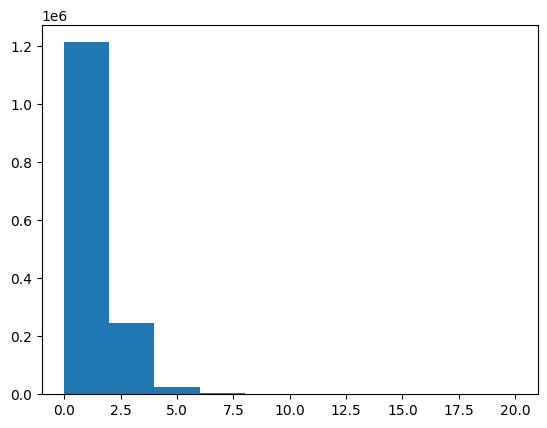

In [30]:
plt.hist(concurrency)

## Save events to disk

In [31]:
labeled_events.to_pickle(DIRECTION_LABEL_FILE_PATH)

In [32]:
DIRECTION_LABEL_FILE_PATH

PosixPath('../data/direction_labels/USDJPY-1m-20210101-20241231-CUSUM.pkl')